<div style="float:left;font-size:20px;">
    <h1>Interpolation ND Error</h1>
</div><div style="float:right;"><img src="../../assets/banner.jpg"></div>

Source: https://nbviewer.jupyter.org/github/pierre-haessig/stodynprog/blob/master/stodynprog/linear_interp_benchmark.ipynb

In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
# Tweak how images are plotted with imshow
mpl.rcParams['image.interpolation'] = 'none' # no interpolation
mpl.rcParams['image.origin'] = 'lower' # origin at lower left corner
mpl.rcParams['image.cmap'] = 'RdBu_r'

In [4]:
from scipy.interpolate import (
    LinearNDInterpolator, RectBivariateSpline,
    RegularGridInterpolator)

In [5]:
def gridpoints(n, a=-1, b=1):
    """Returns Chebyshev nodes of specified dimensions.
    
    int n: Number of Chebyshev nodes
    float a: Interval minimum
    float b: Interval maximum
    
    Further reading: https://en.wikipedia.org/wiki/Chebyshev_nodes
    """
    x_i = 0.5*(b + a) + 0.5*(b - a) * np.cos( np.pi * (np.arange(1, n + 1) - 0.5)/n)
    return np.array(sorted(x_i)  )

In [277]:
def f_3d(x,y,z):
    '''a function with 3D input to interpolate on [0,1]'''
    twopi = 2*pi
    return np.cos(x*2*pi)*np.cos(y*2*pi)*np.cos(z*2*pi)

def f_2d(x,y):
    '''a function with 2D input to interpolate on [0,1]'''
    twopi = 2*pi
    return np.cos(x*2*pi) #*np.cos(y*2*pi)


In [7]:
# Generate train set
Ndata = 3
#xgrid = np.linspace(0,1, Ndata)
#ygrid = np.linspace(0,1, Ndata+1) # use a slighly different size to check differences
#zgrid = np.linspace(0,1, Ndata+2)
xgrid = gridpoints(Ndata, 0, 1)
ygrid = gridpoints(Ndata+1, 0, 1)
zgrid = gridpoints(Ndata+2, 0, 1)

# Reshape arguments specify dimensions in x, y, z. -1 infers length from array.
# (-1, 1, 1) -> Shape (len(arr), 1, 1)
values = f_3d(xgrid.reshape(-1,1,1), ygrid.reshape(1,-1,1), zgrid)

# Train interpolation
f_3d_interp = RegularGridInterpolator((xgrid, ygrid, zgrid), values)
print(f'Grid range:\nX = ({min(xgrid)}, {max(xgrid)})\nY = ({min(ygrid)}, {max(ygrid)})\nZ = ({min(zgrid)}, {max(zgrid)}')

Grid range:
X = (0.06698729810778065, 0.9330127018922194)
Y = (0.03806023374435663, 0.9619397662556434)
Z = (0.024471741852423234, 0.9755282581475768


### Error analysis 2D

In [290]:
# Evaluate performance
#n_points = np.arange(13, 40) # Range of points to evaluate accuracy over
n_points = [13]

# Evaluation points
Ninterp = 200
xinterp = np.linspace(-0.98, 0.98, Ninterp)
yinterp = np.array([0]) #np.linspace(-0.98, 0.98, Ninterp)

points_x, points_y = np.broadcast_arrays(xinterp.reshape(-1,1,1), yinterp)
coord = np.vstack((points_x.flatten(), # a weird formula !
                   points_y.flatten(),
                   ))


residual_bary, residual_bary_cheby = [], []
errors_lin, errors_cubic, errors_bary = [], [], []
errors_lin_cheby, errors_cubic_cheby, errors_bary_cheby = [], [], []

for n in n_points:

    # True function
    #value_true = f_1d(xinterp)
    value_true = f_2d(xinterp.reshape(-1, 1), yinterp)

    xgrid = np.linspace(-1, 1, n)
    ygrid =  np.linspace(-1, 1, 2) # np.linspace(-1, 1, n)
    #values = f_2d(xgrid.reshape(-1, 1), ygrid)
    #values = f_1d(xgrid.reshape(-1, 1))
    values = [[f_2d(x, y)] for x in xgrid for y in ygrid]
    

#     xgrid_cheby = gridpoints(n, -1, 1)
#     ygrid_cheby = gridpoints(n, -1, 1)
#     values_cheby = f_2d(xgrid_cheby.reshape(-1, 1), ygrid_cheby)
#     #values_cheby = f_1d(xgrid_cheby)

    # Train interpolation
    f_2d_interp = RegularGridInterpolator((xgrid, ygrid), values)
    #f_2d_interp_cheby = RegularGridInterpolator((xgrid_cheby, ygrid_cheby), values_cheby)
#     f_2d_interp = RegularGridInterpolator(xgrid, values)
#     f_2d_interp_cheby = RegularGridInterpolator((xgrid_cheby.reshape(-1, 1)), values_cheby)
    
    value_interp = f_2d_interp(coord.T).reshape(len(xinterp), len(yinterp))
    #value_interp_cheby = f_2d_interp_cheby(coord.T).reshape(len(xinterp), len(yinterp))
    

    value_error = np.abs(value_interp - value_true)
    #value_error_cheby = np.abs(value_interp_cheby - value_true)
    
    
    residual_bary.append(value_error)
    #residual_bary_cheby.append(value_error_cheby)
    
    errors_bary.append(np.max(np.abs(value_error)))
    #errors_bary_cheby.append(np.max(np.abs(value_error_cheby)))

ValueError: There are 13 points and 26 values in dimension 0

In [287]:
ygrid

array([-1.        , -0.83333333, -0.66666667, -0.5       , -0.33333333,
       -0.16666667,  0.        ,  0.16666667,  0.33333333,  0.5       ,
        0.66666667,  0.83333333,  1.        ])

In [261]:
np.shape(residual_bary)

(27, 200, 1)

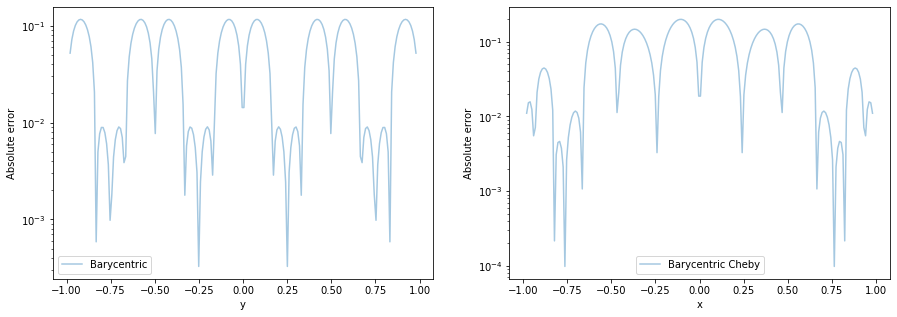

In [270]:
n = 0
fig, ax = plt.subplots(1, 2, figsize=(15,5))
residual_bary_cheby = np.array(residual_bary_cheby)

# for i in range(len(residual_bary[n])):
#     #plt.plot(x_eval, y_error_lin, color='r', label='Linear')
#     #plt.plot(x_eval, y_error_cubic, color='b', alpha=0.4, label='Cubic')
#     # 3D
#     ax[0].plot(yinterp, residual_bary_cheby[n, i], alpha=0.4, label=f'Barycentric y{i}')
#     ax[1].plot(xinterp, residual_bary_cheby[n,:,i], alpha=0.4, label=f'Barycentric x{i}')
# 2D
ax[0].plot(xinterp, residual_bary[n], alpha=0.4, label='Barycentric')
ax[1].plot(xinterp, residual_bary_cheby[n], alpha=0.4, label='Barycentric Cheby')
ax[0].set_xlabel('y')
ax[1].set_xlabel('x')
ax[0].set_ylabel('Absolute error')
ax[1].set_ylabel('Absolute error')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].legend()
ax[1].legend();

Text(0, 0.5, 'Absolute error')

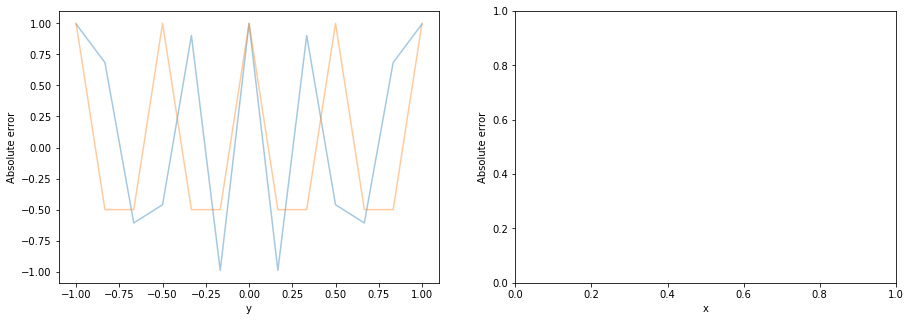

In [276]:
n = 0
fig, ax = plt.subplots(1, 2, figsize=(15,5))
residual_bary_cheby = np.array(residual_bary_cheby)
# 2D
ax[0].plot(xgrid, values_cheby[0], alpha=0.4, label='Barycentric')
ax[0].plot(xgrid, values[0], alpha=0.4, label='Barycentric Cheby')
ax[0].set_xlabel('y')
ax[1].set_xlabel('x')
ax[0].set_ylabel('Absolute error')
ax[1].set_ylabel('Absolute error')

#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[0].legend()
#ax[1].legend();

### Error analysis 3D

In [55]:
# Evaluate performance
n_points = np.arange(3, 40) # Range of points to evaluate accuracy over

# Evaluation points
Ninterp = 11
xinterp = np.linspace(0.11, 0.89, Ninterp)
yinterp = np.linspace(0.11, 0.89, Ninterp) # use a slighly different size to check differences
zinterp = np.linspace(0.11, 0.89, Ninterp) # small dimension to avoid size explosion

points_x, points_y, points_z = np.broadcast_arrays(xinterp.reshape(-1,1,1), yinterp.reshape(1,-1,1), zinterp)
coord = np.vstack((points_x.flatten(), # a weird formula !
                   points_y.flatten(),
                   points_z.flatten()
                   ))


residual_bary, residual_bary_cheby = [], []
errors_lin, errors_cubic, errors_bary = [], [], []
errors_lin_cheby, errors_cubic_cheby, errors_bary_cheby = [], [], []

for n in n_points:

    xgrid = np.linspace(0, 1, n)
    ygrid = np.linspace(0, 1, n)
    zgrid = np.linspace(0, 1, n)
    values = f_3d(xgrid.reshape(-1,1,1), ygrid.reshape(1,-1,1), zgrid)

    xgrid_cheby = gridpoints(n, 0, 1)
    ygrid_cheby = gridpoints(n, 0, 1)
    zgrid_cheby = gridpoints(n, 0, 1)
    values_cheby = f_3d(xgrid_cheby.reshape(-1,1,1), ygrid_cheby.reshape(1,-1,1), zgrid_cheby)

    # Train interpolation
    f_3d_interp = RegularGridInterpolator((xgrid, ygrid, zgrid), values)
    f_3d_interp_cheby = RegularGridInterpolator((xgrid_cheby, ygrid_cheby, zgrid_cheby), values_cheby)
    
    value_interp = f_3d_interp(coord.T).reshape(len(xinterp), len(yinterp), len(zinterp))
    value_interp_cheby = f_3d_interp_cheby(coord.T).reshape(len(xinterp), len(yinterp), len(zinterp))
    
    value_true = f_3d(xinterp.reshape(-1,1,1), yinterp.reshape(1,-1,1), zinterp)
    value_error = np.abs(value_interp - value_true)
    value_error_cheby = np.abs(value_interp_cheby - value_true)
    
    
    residual_bary.append(value_error)
    residual_bary_cheby.append(value_error_cheby)
    
    errors_bary.append(np.max(np.abs(value_error)))
    errors_bary_cheby.append(np.max(np.abs(value_error_cheby)))

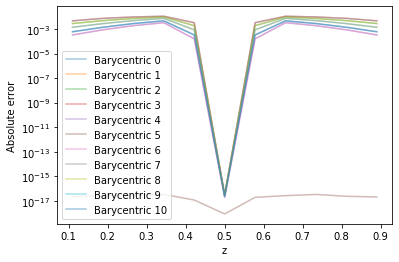

In [61]:
n = 30 -3

for i in range(len(residual_bary[n])):
    #plt.plot(x_eval, y_error_lin, color='r', label='Linear')
    #plt.plot(x_eval, y_error_cubic, color='b', alpha=0.4, label='Cubic')
    plt.plot(zinterp, residual_bary_cheby[n][0][i], alpha=0.4, label=f'Barycentric {i}')
plt.xlabel('z')
plt.ylabel('Absolute error')
plt.yscale('log')
plt.legend();

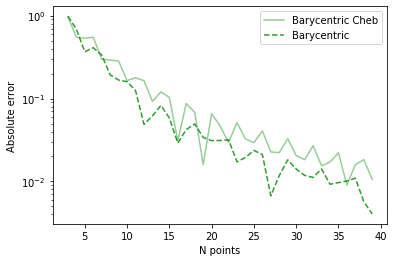

In [15]:
#plt.plot(n_points, errors_lin_cheby, color='r', alpha=0.4, label='Linear Cheb')
#plt.plot(n_points, errors_cubic_cheby, color='b', alpha=0.4, label='Cubic Cheb')
plt.plot(n_points, errors_bary_cheby, color='g', alpha=0.4, label='Barycentric Cheb')
#plt.plot(n_points, errors_lin, color='r', alpha=0.8, label='Linear', ls='--')
#plt.plot(n_points, errors_cubic, color='b', alpha=0.8, label='Cubic', ls='--')
plt.plot(n_points, errors_bary, color='g', alpha=0.8, label='Barycentric', ls='--')
#plt.plot(n_points, error_theory, color='y', alpha=0.8, label='Theory', ls='--')
plt.xlabel('N points')
plt.ylabel('Absolute error')
plt.yscale('log')
plt.legend();